<a href="https://colab.research.google.com/github/TanyaClementine/gru-stockprice-prediction/blob/main/GRU_STOCK_RPRICE_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 6.7987e-04 - val_loss: 0.0038
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.0555e-06 - val_loss: 0.0027
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.6628e-06 - val_loss: 0.0029
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.9112e-06 - val_loss: 0.0025
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.7777e-06 - val_loss: 0.0023
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 3.2753e-06 - val_loss: 0.0021
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 3.4201e-06 - val_loss: 0.0018
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.9207e-06 - val_loss: 0.0023
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 2.9550e-06 - val_loss: 0.0020
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 3.0788e-06 - val_loss: 0.0015
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6283e-04
Test Loss (MSE): 0.001454955548979342
19/19 ━━━━━━

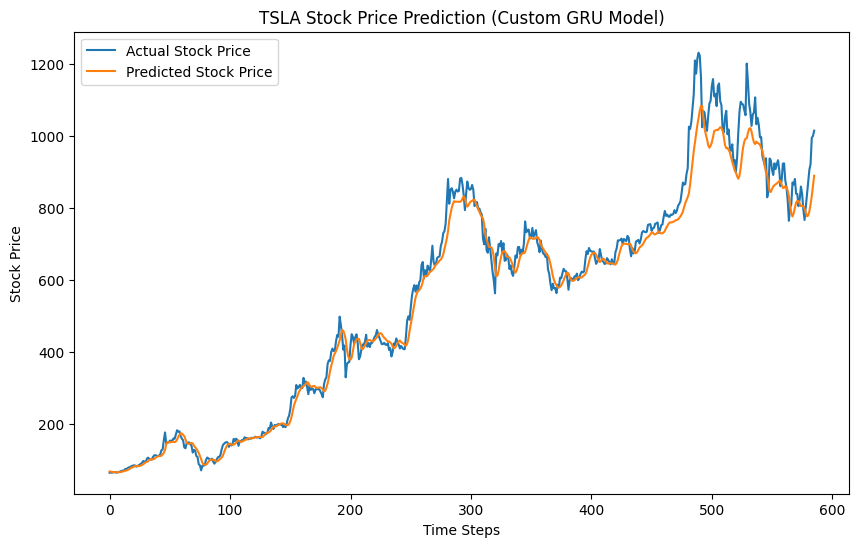

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import tensorflow as tf

file_path = 'TSLA.csv'
df = pd.read_csv(file_path)



df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)


features = df.drop(columns=['Close'])
target = df['Close']


scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))


def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)



SEQ_LENGTH = 30
X, y = create_sequences(scaled_features, scaled_target, SEQ_LENGTH)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


class CustomGRU(tf.keras.layers.Layer):
    def __init__(self, units):
        super(CustomGRU, self).__init__()
        self.units = units
        self.state_size = units


    def build(self, input_shape):
        #Weights for Update gate
        self.Wz = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.Uz = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', trainable=True)
        self.bz = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)


        #Weights for Reset gate
        self.Wr = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.Ur = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', trainable=True)
        self.br = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)


        #Weights for candidate hidden state
        self.Wh = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.Uh = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', trainable=True)
        self.bh = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)


    def call(self, inputs, states):
        h_prev = states[0]


        # Update gate
        z = tf.sigmoid(tf.matmul(inputs, self.Wz) + tf.matmul(h_prev, self.Uz) + self.bz)


        # Reset gate
        r = tf.sigmoid(tf.matmul(inputs, self.Wr) + tf.matmul(h_prev, self.Ur) + self.br)


        # Candidate hidden state
        h_hat = tf.tanh(tf.matmul(inputs, self.Wh) + tf.matmul(r * h_prev, self.Uh) + self.bh)


        # Current hidden state
        h = (1 - z) * h_prev + z * h_hat
        return h, [h]



class CustomGRUModel(tf.keras.Model):
    def __init__(self, units):
        super(CustomGRUModel, self).__init__()
        self.gru1 = tf.keras.layers.RNN(CustomGRU(units), return_sequences=True)
        self.gru2 = tf.keras.layers.RNN(CustomGRU(units // 2))
        self.dense = tf.keras.layers.Dense(1)


    def call(self, inputs):

        h1 = self.gru1(inputs)
        h2 = self.gru2(h1)
        output = self.dense(h2)
        return output

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


model = CustomGRUModel(units=64)
model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))



loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")


predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test_actual = scaler.inverse_transform(y_test)


plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label='Actual Stock Price')
plt.plot(predicted, label='Predicted Stock Price')
plt.title('TSLA Stock Price Prediction (Custom GRU Model)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
train_acc = history.history["loss"][-1]
training_accuracy = (1 - train_acc)*100
test_acc = history.history["val_loss"][-1]
test_accuracy = (1 - test_acc)*100

print(f"Training Accuracy : {training_accuracy:.2f}%")
print(f"Test Accuracy : {test_accuracy:.2f}%")

Training Accuracy : 100.00%
Test Accuracy : 99.85%
